<a href="https://colab.research.google.com/github/moemag/Image-Segmentation/blob/main/Image%20segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
import cv2
from sklearn.cluster import SpectralClustering


[link text](https://)Reading images & groundTruth

In [ ]:
img_train = []
img_test = []
img_valid = []


gt_train = []
gt_test = []
gt_valid = []

for i in range(1, 51):
  image_temp = Image.open('drive/MyDrive/data/images/test/i ('+str(i)+').jpg')
  img_test.append(np.array(image_temp))
  mat = scipy.io.loadmat('drive/MyDrive/data/groundTruth/test/j ('+str(i)+').mat')
  temp = []
  for i in range(mat['groundTruth'][0].size):
    for j in range(mat['groundTruth'][0][i][0][0].size):
      temp.append(np.array(mat['groundTruth'][0][i][0][0][j]))
  gt_test.append(temp)


In [ ]:
def VisualizeGroundT(img, ground_truth):
  fig,axes = plt.subplots(1, 1+len(ground_truth))
  fig.set_size_inches((30,10))
  axes[0].imshow(img)
  for i, gt in zip(range(len(ground_truth)) ,ground_truth):
    axes[i+1].imshow(gt)

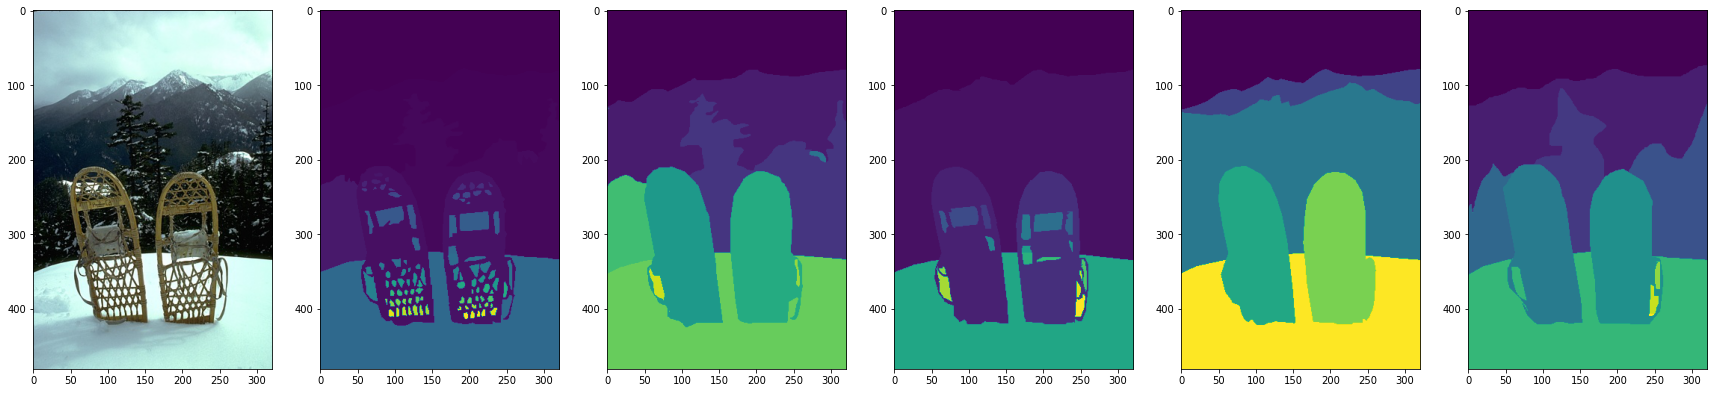

In [ ]:
VisualizeGroundT(img_test[0], gt_test[0])

Implemented K-means

In [ ]:
def _KMeans(image, k):
  clustering = np.zeros(image.shape[0])

  indices = np.random.choice(image.shape[0], k, replace=False)

  centroids = image[indices]
  for i in range(10):
    # cluster assignment
    for n in range(len(image)):
      distances = []
      for row in centroids:
        distances.append(((image[n]-row)**2).sum())
      min_value = min(distances)
      clustering[n] = distances.index(min_value)

    clusters = []
    for i in range(k):
      clusters.append( np.where(clustering == i)[0] )

    new_centroids = []
    for i, c in zip(range(k), clusters):
      new_centroids.append(np.mean(image[c], axis=0))

    if np.sum(np.array(new_centroids) - np.array(centroids)) == 0:
      break
    centroids = new_centroids

  return clustering, centroids

In [ ]:
for n, image in zip(range(len(img_test)) ,img_test):
  for i,k in zip(range(5), [3,5,7,9,11]):
    image = np.array(image)
    x, y, z = image.shape
    image_2d = image.reshape(x*y, z)

    kmeans_cluster = KMeans(n_clusters=k)
    kmeans_cluster.fit(image_2d/255)
    cluster_centers = kmeans_cluster.cluster_centers_
    cluster_labels = kmeans_cluster.labels_
    segmented_image = np.array(cluster_centers[cluster_labels].reshape(x, y, z))
    Image.fromarray((segmented_image * 255).astype(np.uint8)).save("drive/MyDrive/data/output/test/"+ str(n) +" k" + str(k) +".jpg")

In [ ]:
def kMeansVisualization():
  for i in range(5):
    fig,axes = plt.subplots(1, 2)
    fig.set_size_inches((10,5))
    axes[0].imshow(Image.open('drive/MyDrive/data/output/test/'+ str(i) +" k5.jpg"))
    axes[1].imshow(gt_test[i][0])

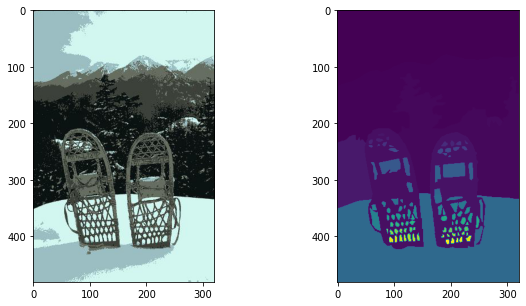

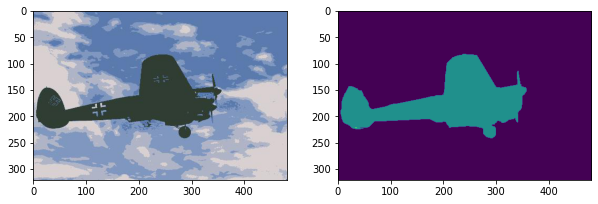

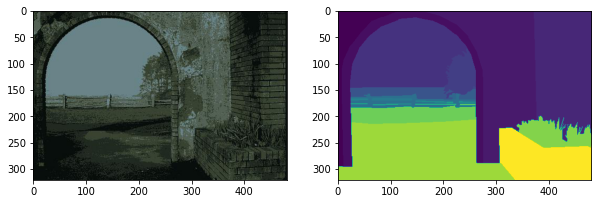

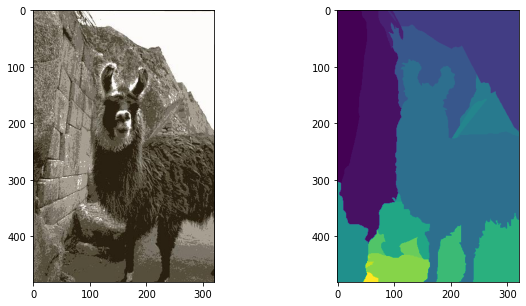

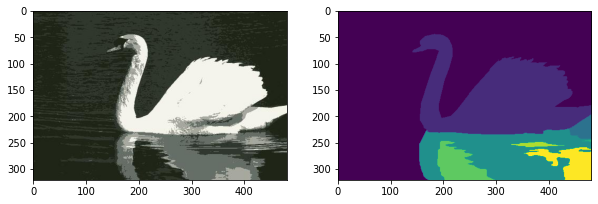

In [ ]:
kMeansVisualization()

Normalized cuts

In [ ]:
from sklearn.metrics import pairwise_distances
final_ncuts_images=[]
for i in range(5):

  image = img_test[i]
  image_data = np.asarray(image)
  res = cv2.resize(image_data, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
  data_img=cv2.GaussianBlur(res,(7,7),0)
  unrolled=data_img.reshape(-1,3)

  distance_matrix= pairwise_distances(unrolled, metric='euclidean')

  affinity = []
  for row in distance_matrix:
    for d in row:
      aff= np.exp(-0.01 * d ** 2)
      affinity.append(aff)


  affinity = np.array(affinity)
  affinity=affinity.reshape(10000,10000)
  clustering = SpectralClustering(n_clusters=5, assign_labels="discretize", affinity="precomputed").fit(affinity)

  colors = [[52,52,52],[126, 160, 246],[255,255,255],[255,51,51],[102,204,0],[0,255,255],[173, 236, 135],[51,51,255],[126, 0, 151],[200,200,200],[100,100,100]]
  newImage = []
  for k in range(0,10000):
    newImage.append(colors[clustering.labels_[k]])

  newImage=np.array(newImage).reshape(100,100,3)
  final_ncuts_images.append(newImage)

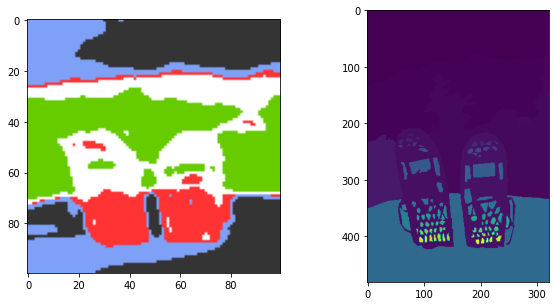

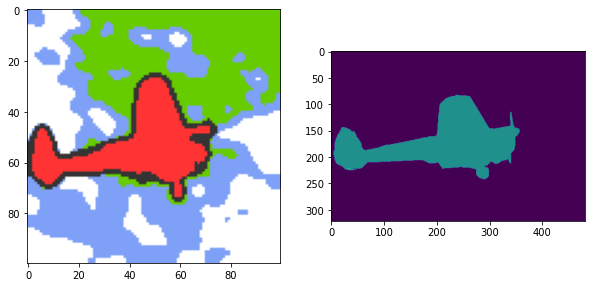

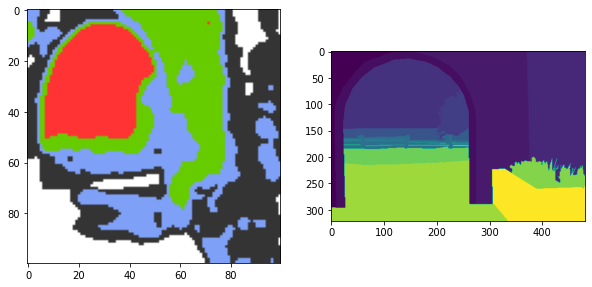

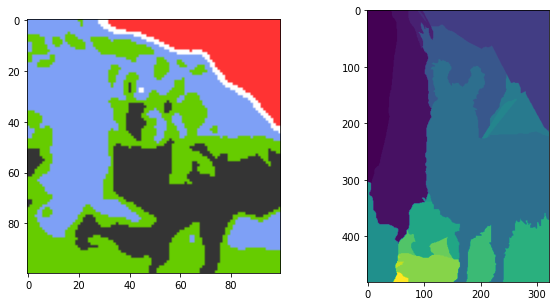

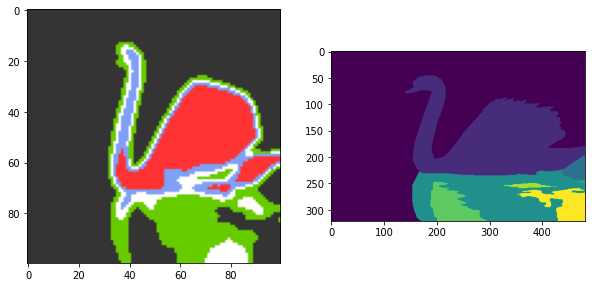

In [ ]:
for i in range(5):
  fig,axes = plt.subplots(1, 2)
  fig.set_size_inches((10,5))
  axes[0].imshow(final_ncuts_images[i])
  axes[1].imshow(gt_test[i][0])

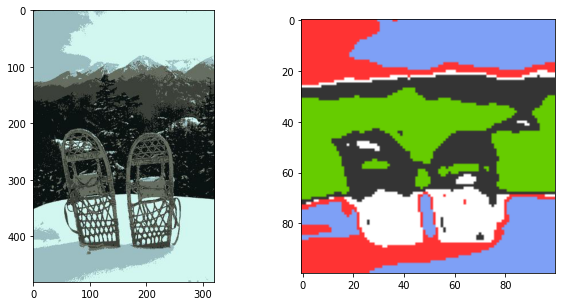

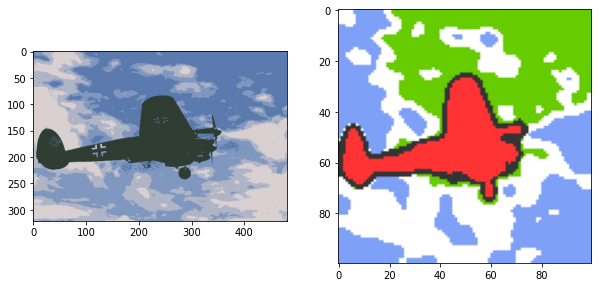

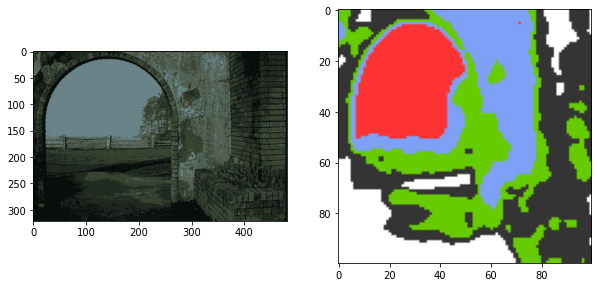

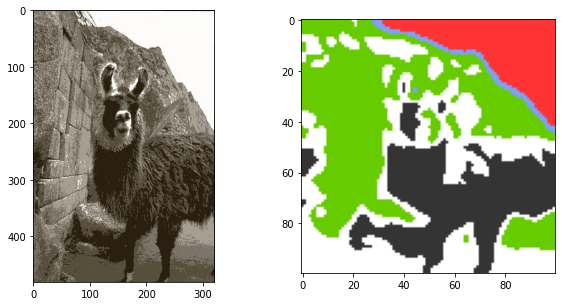

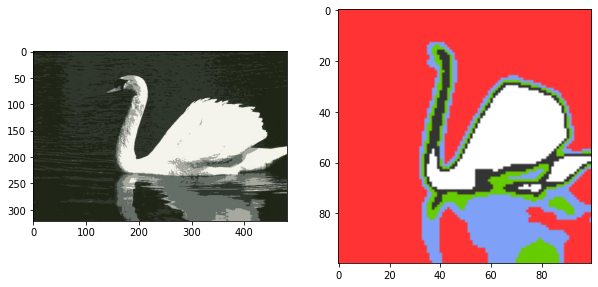

In [ ]:
for i in range(5):
  fig,axes = plt.subplots(1, 2)
  fig.set_size_inches((10,5))
  axes[0].imshow(Image.open('drive/MyDrive/data/output/test/'+ str(i) +" k5.jpg"))
  axes[1].imshow(final_ncuts_images[i])